In [1]:
!pip3 install matplotlib scanpy scipy

In [2]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm 
import pickle as pkl
from typing import Tuple, Union
import scipy

In [3]:
import scanpy as sc

from warnings import filterwarnings
filterwarnings('ignore')

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

np.set_printoptions(precision=3)

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.0 statsmodels==0.13.5 pynndescent==0.5.8


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1.1 Datasets

In [5]:
# !wget https://saturn-public-data.s3.us-east-2.amazonaws.com/cancer-immunotherapy-challenge/data/sc_training.h5ad

In [6]:
# !wget https://saturn-public-data.s3.us-east-2.amazonaws.com/cancer-immunotherapy-challenge/code/sc_training_visualization.ipynb

In [7]:
# !wget https://saturn-public-data.s3.us-east-2.amazonaws.com/cancer-immunotherapy-challenge/data/clone_information.csv

In [8]:
# !wget https://saturn-public-data.s3.us-east-2.amazonaws.com/cancer-immunotherapy-challenge/data/guide_abundance.csv

In [9]:
# !wget https://saturn-public-data.s3.us-east-2.amazonaws.com/cancer-immunotherapy-challenge/data/scRNA_ATAC.h5

In [10]:
# !wget https://stringdb-static.org/download/protein.links.v11.5/10090.protein.links.v11.5.txt.gz
# !gunzip ./10090.protein.links.v11.5.txt.gz

In [11]:
# !wget https://stringdb-static.org/download/protein.info.v11.5/10090.protein.info.v11.5.txt.gz
# !gunzip ./10090.protein.info.v11.5.txt.gz

For *read_h5ad()*, see [scanpy documentation](https://scanpy.readthedocs.io/en/stable/generated/scanpy.read_h5ad.html)

In [12]:
adata = sc.read_h5ad('../data/sc_training.h5ad')
adata

AnnData object with n_obs × n_vars = 28697 × 15077
    obs: 'gRNA_maxID', 'state', 'condition', 'lane'
    layers: 'rawcounts'

For *adata* object type, see [AnnData documentation](https://anndata.readthedocs.io/en/stable/generated/anndata.AnnData.html#anndata.AnnData)

In [13]:
adata.obs

,gRNA_maxID,state,condition,lane
053l1_AAACCTGAGATGTCGG-1,ONE-NON-GENE-SITE-7,terminal exhausted,Unperturbed,lane1
053l1_AAACCTGAGCAACGGT-1,Tox2-3,effector,Tox2,lane1
053l1_AAACCTGAGTACGACG-1,Tpt1-2,effector,Tpt1,lane1
053l1_AAACCTGAGTCGTTTG-1,Tox2-3,terminal exhausted,Tox2,lane1
053l1_AAACCTGAGTGAAGAG-1,Tcf7-2,effector,Tcf7,lane1
...,...,...,...,...
053l4_TTTGTCATCAGGTTCA-1,Tox2-3,other,Tox2,lane4
053l4_TTTGTCATCAGTGTTG-1,Dvl2-3,cycling,Dvl2,lane4
053l4_TTTGTCATCCTCGCAT-1,Zeb2-2,cycling,Zeb2,lane4
053l4_TTTGTCATCTTCAACT-1,Sox4-3,cycling,Sox4,lane4


In [14]:
prot_links = pd.read_csv('../data/10090.protein.links.v11.5.txt', sep=' ')
prot_links

,protein1,protein2,combined_score
0,10090.ENSMUSP00000000001,10090.ENSMUSP00000031145,161
1,10090.ENSMUSP00000000001,10090.ENSMUSP00000071486,208
2,10090.ENSMUSP00000000001,10090.ENSMUSP00000119330,183
3,10090.ENSMUSP00000000001,10090.ENSMUSP00000066449,259
4,10090.ENSMUSP00000000001,10090.ENSMUSP00000061539,229
...,...,...,...
14496353,10090.ENSMUSP00000141183,10090.ENSMUSP00000130793,150
14496354,10090.ENSMUSP00000141183,10090.ENSMUSP00000135905,150
14496355,10090.ENSMUSP00000141183,10090.ENSMUSP00000139505,248
14496356,10090.ENSMUSP00000141183,10090.ENSMUSP00000048340,211


In [15]:
prot_info = pd.read_csv('../data/10090.protein.info.v11.5.txt', sep='\t')

prot_info

,#string_protein_id,preferred_name,protein_size,annotation
0,10090.ENSMUSP00000000001,Gnai3,354,Guanine nucleotide-binding protein G(k) subuni...
1,10090.ENSMUSP00000000003,Pbsn,174,Probasin
2,10090.ENSMUSP00000000010,Hoxb9,250,Homeobox protein Hox-B9; Sequence-specific tra...
3,10090.ENSMUSP00000000028,Cdc45,566,Cell division control protein 45 homolog; Requ...
4,10090.ENSMUSP00000000049,Apoh,345,Beta-2-glycoprotein 1; Binds to various kinds ...
...,...,...,...,...
22043,10090.ENSMUSP00000141161,Gm20911,222,annotation not available
22044,10090.ENSMUSP00000141166,ENSMUSG00000101645,938,annotation not available
22045,10090.ENSMUSP00000141169,Carf,689,Calcium-responsive transcription factor; Acts ...
22046,10090.ENSMUSP00000141173,ENSMUSG00000100608,222,annotation not available


# 1.2 Preprocess data

In [16]:
# One-hot encoding of the categorical 'lane' variable 

obs = adata.obs
lane_data = obs['lane'].values
lane_data_unique = np.sort(list(set(lane_data))).reshape(-1, 1)

# If the obs['lane'] is categorical variable, it's better to encode it using one-hot encoding 
# before adding it to the X_train to avoid any bias in the model.
encoder = OneHotEncoder()
one_hot_encoded = np.array(encoder.fit_transform(lane_data_unique).toarray())
lane_data_dict = {lane_data_unique[i][0]: one_hot_encoded[i] for i in 
                  range(len(lane_data_unique))}
one_hot_lane_data = [lane_data_dict[lane] for lane in lane_data]

# embeds one_hot_lane_data into expression data
# one_hot_lane_data = np.array(one_hot_lane_data)
# print(one_hot_lane_data)
# from scipy.sparse import hstack
# expression_data = hstack((expression_data, one_hot_lane_data)).toarray()[-4:]

In [94]:
obs = adata.obs
genes = adata.var.index.tolist()


expression_data = adata.X
print(expression_data.shape)
print(obs.shape)
# expression_data = pd.DataFrame(expression_data.toarray())
# expression_data = expression_data.set_index(obs.index)


expression_data_csc = expression_data.tocsc()
X_labels = np.array(obs['condition'].tolist())

test_genes = ['Ets1', 'Fosb', 'Mafk', 'Stat3']
validation_genes = ['Aqr', 'Bach2', 'Bhlhe40']

#### HOW WE IDEALLY SHOULD GET OUR TRAINING DATASET

# # PROBLEM: Test and validation gene expression vectors are not given!
# # Create test DataFrame
# test_indices = obs[obs['condition'].isin(test_genes)].index
# X_test = expression_data.loc[test_indices]

# # Create validation DataFrame
# validation_indices = obs[obs['condition'].isin(validation_genes)].index
# X_val = expression_data.loc[validation_indices]

# # Create training DataFrame
# train_indices = expression_data.index.difference(test_indices).difference(validation_indices)
# X_train = expression_data.loc[train_indices]




############################################

#### HOW WE HAVE RETRIEVED OUR DATA SET ####
# Note that this is wrong because we filter 
# on our features, not our samples


test_indices = [genes.index(x) for x in test_genes if x in genes]
validation_indices = [genes.index(x) for x in validation_genes if x in genes]
 
X_test = expression_data_csc[:, test_indices]
X_test = X_test.tocsr()
X_val = expression_data_csc[:, validation_indices]
X_val = X_val.tocsr()

all_indices = np.arange(expression_data_csc.shape[1])
rm_indices = test_indices + validation_indices
rm_indices.sort()
keep_indices = np.setdiff1d(np.array(all_indices), np.array(rm_indices))

expression_data_csc = expression_data_csc[:, keep_indices]
X_train = expression_data_csc.tocsr()

############################################

obs_cond_idx = obs.set_index('condition')

exclude_list = ['Unperturbed', 'Fzd1', 'P2rx7']
dropped_obs = obs_cond_idx.drop(index=exclude_list)

removed_indices = obs_cond_idx.index.isin(exclude_list)
X_train, X_test, X_val, X_labels = X_train[~removed_indices],\
                                    X_test[~removed_indices],\
                                    X_val[~removed_indices],\
                                    X_labels[~removed_indices]
X_train, X_test, X_val, X_labels = X_train.toarray(), X_test.toarray(),\
                                  X_val.toarray(), X_labels
print(np.shape(X_train))
print(np.shape(X_labels))
print(np.shape(X_test))

(28697, 15077)
(28697, 4)
(23411, 15070)
(23411,)
(23411, 4)


Now we have our train, test and validation samples. 



In [18]:
states = ['progenitor', 'effector', 'terminal exhausted', 'cycling', 'other']
ground_truth = {}

for gene in genes:
  state_frequency = {state: 0 for state in states}
  rows = obs[obs['condition'] == gene]

  if not rows.empty:  
    for index, row in rows.iterrows():
        state = row['state']
        if state not in states:
          state_frequency['other'] += 1
        else:
          state_frequency[state] += 1
    
    total_count = sum(state_frequency.values())
    for state, count in state_frequency.items():
        state_frequency[state] = count / total_count
    
    ground_truth[gene] = list(state_frequency.values())

Now we have a dictionary that stores the ground truth, i.e. the cell state frequencies, for each gene. Note that each list in this dictionary sums to 1, as required. We have 64 ground truth vectors because of the 66 knockout experiments that are used for training purposes, 2 did not pass quality control (see: [challenge 1 document](https://drive.google.com/file/d/1rR5oIhETmyVu6Uo5BsWjIokdBZctKzCE/view)). 

Next up, we'll have to generate our y_data and filter the unperturbed, and genes that didn't pass the quality control from our training and testing data.

In [19]:
y_data_dict = ground_truth.copy()
y_data = pd.DataFrame.from_dict(y_data_dict, orient='index', 
                                         columns=['progenitor', 'effector', 
                                         'terminal exhausted', 'cycling', 
                                         'other'])
y_data_expand = pd.DataFrame(columns=y_data.columns, index=dropped_obs.index)
idx = 0
for condition, row in dropped_obs.iterrows():
    gene = condition
    state_data = y_data.loc[gene]
    y_data_expand.iloc[idx] = state_data
    idx += 1

y_train = y_data_expand
y_train

,progenitor,effector,terminal exhausted,cycling,other
condition,,,,,
Tox2,0.017309,0.057004,0.367874,0.53081,0.027002
Tpt1,0.44,0.16,0.12,0.28,0.0
Tox2,0.017309,0.057004,0.367874,0.53081,0.027002
Tcf7,0.104377,0.292929,0.313131,0.276094,0.013468
Tox2,0.017309,0.057004,0.367874,0.53081,0.027002
...,...,...,...,...,...
Tox2,0.017309,0.057004,0.367874,0.53081,0.027002
Dvl2,0.02439,0.115509,0.304188,0.549471,0.006443
Zeb2,0.017483,0.115385,0.282051,0.439394,0.145688


In [20]:
X = X_train
X.shape

(23411, 15070)

In [21]:

obs = obs.reindex(y_train.index)
y_train = np.array(y_train)

y = y_train
y

array([[0.017309023771059313, 0.05700438495268867, 0.36787445188091394,
        0.5308100623124856, 0.027002077082852526],
       [0.44, 0.16, 0.12, 0.28, 0.0],
       [0.017309023771059313, 0.05700438495268867, 0.36787445188091394,
        0.5308100623124856, 0.027002077082852526],
       ...,
       [0.017482517482517484, 0.11538461538461539, 0.28205128205128205,
        0.4393939393939394, 0.1456876456876457],
       [0.0696969696969697, 0.11212121212121212, 0.2909090909090909,
        0.5121212121212121, 0.015151515151515152],
       [0.024390243902439025, 0.1155085135757018, 0.3041877588587207,
        0.5494707777266452, 0.006442705936493327]], dtype=object)

In [22]:
y.shape

(23411, 5)

Note that we do not have y_test and y_val, as these will be used to evaluate the performance of our model in the competition. 

In [23]:
import json

network = {}
for label in tqdm(X_labels):
    if label in list(network.keys()):
        continue
    prot_id = prot_info.loc[prot_info['preferred_name'] == label, '#string_protein_id'].values[0]
    related_prots = prot_links.loc[prot_links['protein1'] == prot_id, 'protein2'].values
    related_prots = list(related_prots) + list(prot_links.loc[prot_links['protein2'] == prot_id, 'protein1'].values)
    related_prots = list(set(related_prots))
    related_prots = [prot_info.loc[prot_info['#string_protein_id'] == p, 'preferred_name'].values[0] for p in related_prots if prot_info.loc[prot_info['#string_protein_id'] == p, 'preferred_name'].values[0] in X_labels]
    network[label] = related_prots
    
with open('gene_graph.txt', 'w') as f:
     f.write(json.dumps(network))
        
network

100%|████████████████████████████████████| 23411/23411 [02:07<00:00, 183.75it/s]


{'Tox2': ['Prdm1',
  'Tbx21',
  'Atf2',
  'Id2',
  'Runx3',
  'Ikzf3',
  'Irf2',
  'Yy1',
  'Tox',
  'Foxo1',
  'Nr3c1',
  'Zfp292',
  'Ep300',
  'Lef1',
  'Satb1',
  'Sox4',
  'Tcf7',
  'Egr1',
  'Myb',
  'Rela',
  'Rad21',
  'Batf',
  'Tcf3',
  'Klf2',
  'Eomes'],
 'Tpt1': ['Ldhb', 'Rps6', 'Eef2', 'Ctnnb1', 'Sub1'],
 'Tcf7': ['Prdm1',
  'Ezh2',
  'Tbx21',
  'Atf2',
  'Nr4a1',
  'Dkk3',
  'Runx2',
  'Fzd3',
  'Id2',
  'Dvl1',
  'Runx3',
  'Foxp1',
  'Ikzf3',
  'Zeb2',
  'Dvl2',
  'Hif1a',
  'Yy1',
  'Tox',
  'Fzd6',
  'Foxm1',
  'Stat4',
  'Foxo1',
  'Gsk3b',
  'Nr3c1',
  'Elf1',
  'Zfp292',
  'Tox2',
  'Id3',
  'Ep300',
  'Il12rb2',
  'Lef1',
  'Satb1',
  'Sox4',
  'Egr1',
  'Myb',
  'Rela',
  'Batf',
  'Dvl3',
  'Ctnnb1',
  'Tcf3',
  'Klf2',
  'Eomes'],
 'Il12rb1': ['Irf9',
  'Rela',
  'Ikzf3',
  'Ep300',
  'Il12rb2',
  'Batf',
  'Prdm1',
  'Tbx21',
  'Klf2',
  'Id2',
  'Runx3',
  'Stat4',
  'Eomes'],
 'Ikzf3': ['Prdm1',
  'Ezh2',
  'Tbx21',
  'Runx2',
  'Fzd3',
  'Id2',
  'Runx3',


In [24]:
!pip3 install python-louvain

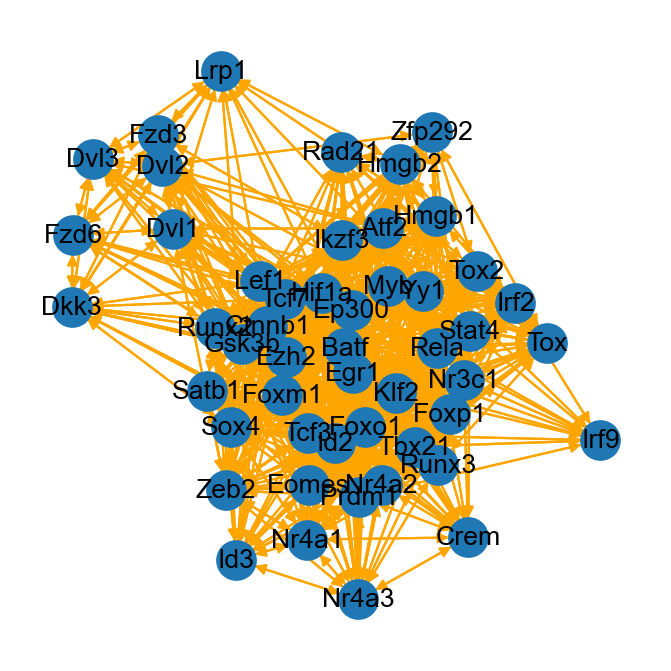

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter

G = nx.DiGraph()

G.add_nodes_from(list(network.keys()))

for gene, related_genes in network.items():
    for related_gene in related_genes:
        G.add_edge(gene, related_gene)

n = 50
top_nodes = sorted(G.degree, key=itemgetter(1), reverse=True)[:n]
top_nodes = [node for node, degree in top_nodes]

subgraph = G.subgraph(top_nodes)

nx.draw(subgraph, with_labels=True, edge_color='orange')
plt.show()

# 2 Graph Attention Transformer architecture

In [26]:
!pip3 install torch
!pip3 install torch-geometric
!pip3 install torch-sparse
!pip3 install torch-scatter

In [27]:
def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    '''
    Courtesy of Aleksa Gordić, https://github.com/gordicaleksa/pytorch-GAT/blob/39c8f0ee634477033e8b1a6e9a6da3c7ed71bbd1/utils/data_loading.py 
    '''
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            # if this edge hasn't been seen so far we add it to the edge index (coalescing - removing duplicates)
            if (src_node, trg_node) not in seen_edges:  # it'd be easy to explicitly remove self-edges (Cora has none..)
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index

In [28]:
from collections import defaultdict

def integer_graph_dict(d):
    mapping = defaultdict(lambda: len(mapping))
    new_d = {}
    for k, v in d.items():
        new_d[mapping[k]] = [mapping[x] for x in v]
        
    return new_d

In [29]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv
from torch_geometric.loader import DataLoader

integer_graph = integer_graph_dict(network)
edge_index = build_edge_index(integer_graph, len(list(network.keys())))
edge_index = torch.tensor(edge_index)

x = torch.tensor(X)
y = torch.from_numpy(y.astype(np.float32))

graph = Data(x=x, edge_index=edge_index, y=y)

In [34]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.hyperparams = {
            'input_heads': 1,
            'learning_rate': 0.005,
            'weight_decay': 5e-3,
            'dropout': 0.6,
            'epochs': 50
        }
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=self.hyperparams['input_heads'])
        self.gat2 = GATv2Conv(dim_h*self.hyperparams['input_heads'], dim_out, heads=1)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=self.hyperparams['learning_rate'],
                                          weight_decay=self.hyperparams['weight_decay'])
        
    
    def forward(self, x, edge_index):
        h = F.dropout(x, p=self.hyperparams['dropout'], training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=self.hyperparams['dropout'], training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)
        


In [40]:
 def train_test_split(data, ratio):
    num_samples = data.shape[0]
    test_val_num = round(num_samples * ratio)
    train_num = num_samples - test_val_num
    
    np.random.seed(42)
    indices = np.random.choice(num_samples, train_num, replace=False)
    train_mask = np.zeros(num_samples)
    train_mask[indices] = 1
    
    test_mask = np.logical_not(train_mask).astype(int)
                             
    return train_mask, test_mask
    
    
def train(model, data, masks):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = model.hyperparams['epochs']
    train_mask, test_mask = masks[0], masks[1]
    test_loss_list = []
    train_loss_list = [] 
    epoch_list = range(1, epochs)
    
    model.train()
    for epoch in tqdm(range(epochs)):
        # Training
        optimizer.zero_grad()
        print(data.x.shape)
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss)

        # Validation
        model.eval()
        with torch.no_grad():
            _, out = model(data.x, data.edge_index)
            test_loss = criterion(out[test_mask], data.y[test_mask])
            test_loss_list.append(test_loss)

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Test Loss: {test_loss:.2f}')
        
        model.train()
        
    loss_plot(train_loss_list, test_loss_list, epoch_list)
          
    return model

def loss_plot(train_loss, test_loss, epochs):
    test_loss = [i.detach().numpy() for i in test_loss][1:]
    train_loss = [i.detach().numpy() for i in train_loss][1:]
    epochs[1:]
    
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

In [41]:
%%time
# Create GAT model
gat = GAT(graph.x.shape[1], 1, graph.y.shape[1])
print(gat)

masks = train_test_split(graph.x, 0.2)

model = train(gat, graph, masks)
lr_print = model.hyperparams['learning_rate']
wd_print = model.hyperparams['weight_decay']
epochs_print = model.hyperparams['epochs']
torch.save(model.state_dict(), f'GAT_{lr_print}_{wd_print}_{epochs_print}')

GAT(
  (gat1): GATv2Conv(15070, 1, heads=1)
  (gat2): GATv2Conv(1, 5, heads=1)
)


  0%|                                                    | 0/50 [00:00<?, ?it/s]

torch.Size([23411, 15070])


  2%|▉                                           | 1/50 [00:01<01:37,  1.99s/it]

Epoch   0 | Train Loss: 1.751 | Test Loss: 2.28
torch.Size([23411, 15070])


  4%|█▊                                          | 2/50 [00:03<01:26,  1.80s/it]

torch.Size([23411, 15070])


  6%|██▋                                         | 3/50 [00:05<01:20,  1.71s/it]

torch.Size([23411, 15070])


  8%|███▌                                        | 4/50 [00:06<01:16,  1.67s/it]

torch.Size([23411, 15070])


  8%|███▌                                        | 4/50 [00:08<01:33,  2.03s/it]


KeyboardInterrupt: 

In [46]:
# loaded_model = GAT(X_test.shape[1], 1, graph.y.shape[1])
# loaded_model.load_state_dict(torch.load(f'GAT_{lr_print}_{wd_print}_{epochs_print}'))

X_test = torch.tensor(X_test)
X_val = torch.tensor(X_val)
print(X_test.shape)
print(edge_index.shape)
test_graph = Data(x=X_test, edge_index=edge_index)
val_graph = Data(x=X_test, edge_index=edge_index)

model.eval()
with torch.no_grad():
    _, test_output = model(test_graph.x, test_graph.edge_index)
    _, val_output = model(val_graph.x, val_graph.edge_index)

print(test_output)

torch.Size([23411, 4])
torch.Size([2, 1754])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (23411x4 and 15070x1)